# Baseline - Part 3: Feature Selection

In [2]:
#Loading key libraries for later analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
pd.set_option('max_colwidth', 1000)
from sklearn.model_selection import cross_val_score, cross_validate,GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Lasso
import functions

In [3]:
def evaluation_score(model,df):
    kfold = StratifiedKFold(n_splits=5,random_state=200,shuffle=True)
    scoring = ('accuracy','precision_macro','recall_macro','f1_macro')

    scores = cross_validate(model, df, y_train, cv=kfold, scoring= scoring, n_jobs = -1)
    sorted(scores.keys())
    accuracy = scores['test_accuracy'].mean()
    precision_macro = scores['test_precision_macro'].mean()
    recall_macro = scores['test_recall_macro'].mean()
    f1_macro = scores['test_f1_macro'].mean()
    print('Accuracy: {},Precision: {},Recall: {},F1 Score: {}'.format(round(accuracy,5),round(precision_macro,5),
                                                                                    round(recall_macro,5),round(f1_macro,5)))

In [4]:
#Read in bank transactions
Train = pd.read_csv(r'Train_trad.csv',low_memory=False,encoding='latin1')
Test = pd.read_csv(r'Test_trad.csv',low_memory=False,encoding='latin1')

In [8]:
#Prepare Final DataFrame
Train.index = Train['Unnamed: 0'].values
Train = functions.drop_column(Train,['Unnamed: 0','local_rule_creation_date'])
Test.index = Test['Unnamed: 0'].values
Test = functions.drop_column(Test,['Unnamed: 0','local_rule_creation_date'])

In [9]:
#Form the final sets
X_train = Train.iloc[:,:-1]
X_test = Test.iloc[:,:-1]
y_train = Train.iloc[:,-1]
y_test = Test.iloc[:,-1]

## 1. Feature Collinearity

In [8]:
#Check for multicollinearity
c = X_num_feat.corr().abs()
s = c.unstack()
corr = sorted(s.items(),key = lambda x: x[1],  reverse=True)
corr = [corr[x] for x in range(len(corr)) if corr[x][1]!=1]
corr[:30]

[(('amount_std', 'debit_binary'), 0.3487961066078567),
 (('debit_binary', 'amount_std'), 0.3487961066078567),
 (('week_of_month_2', 'week_of_month_3'), 0.33886935495399506),
 (('week_of_month_3', 'week_of_month_2'), 0.33886935495399506),
 (('week_of_month_3', 'week_of_month_4'), 0.3260581252278716),
 (('week_of_month_4', 'week_of_month_3'), 0.3260581252278716),
 (('week_of_month_2', 'week_of_month_4'), 0.2933863853368857),
 (('week_of_month_4', 'week_of_month_2'), 0.2933863853368857),
 (('amount_std', 'financing_binary'), 0.2861013639378705),
 (('financing_binary', 'amount_std'), 0.2861013639378705),
 (('financing_binary', 'token_length'), 0.28114900313591634),
 (('token_length', 'financing_binary'), 0.28114900313591634),
 (('amount_std', 'balance_std'), 0.21997780758127355),
 (('balance_std', 'amount_std'), 0.21997780758127355),
 (('amount_std', 'token_length'), 0.19519344151473594),
 (('token_length', 'amount_std'), 0.19519344151473594),
 (('debit_binary', 'token_length'), 0.15176681

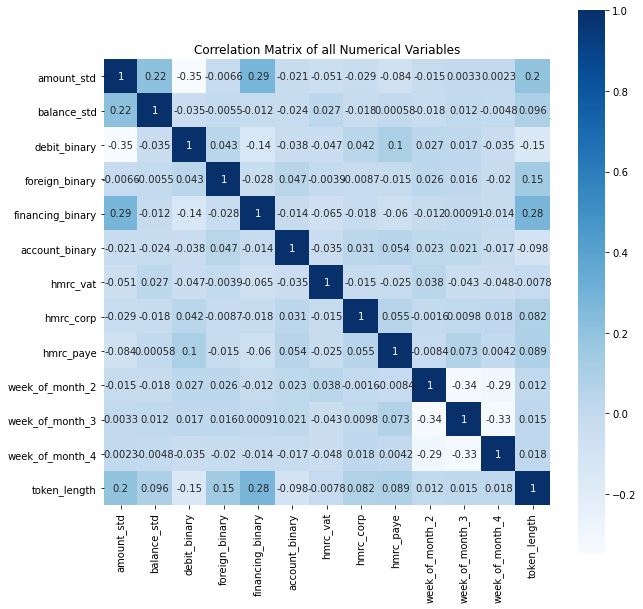

In [9]:
#plot the correlation map between all numerical features
def correlation_map(final_data):
    dfData =final_data.corr()
    plt.subplots(figsize=(10, 10)) 
    sns.heatmap(dfData, annot=True, vmax=1, square=True, cmap="Blues")
    plt.title('Correlation Matrix of all Numerical Variables')
    plt.savefig(r'corr matrix_hybrid.png',bbox_inches='tight')
    
correlation_map(X_num_feat)

In [10]:
#check the collinearity with VIF score, if the VIF score is higher than 10, it is more likely to be correlated
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
#Define the dependent and independent variables
vif1 = pd.DataFrame()
vif1["VIF Factor"] = [variance_inflation_factor(X_num_feat.values, i) for i in range(X_num_feat.shape[1])]
vif1["features"] = X_num_feat.columns
vif1.round(1)

,VIF Factor,features
0,1.3,amount_std
1,1.1,balance_std
2,2.4,debit_binary
3,1.0,foreign_binary
4,1.4,financing_binary
5,1.0,account_binary
6,1.0,hmrc_vat
7,1.0,hmrc_corp
8,1.1,hmrc_paye
9,1.6,week_of_month_2


## 2 Feature Importance： by Lasso regression

In [20]:
#create the lambda range
from sklearn.linear_model import Lasso
lambda_list = np.logspace(-6,6, num=100)

#Fit training data into lasso (still numerical features only)
weights_lasso = []

for lambda_value in lambda_list:    
    lassoreg = Lasso(alpha=lambda_value)
    lassoreg.fit(X_num_feat,y_train)
    weights_lasso.append(lassoreg.coef_) 

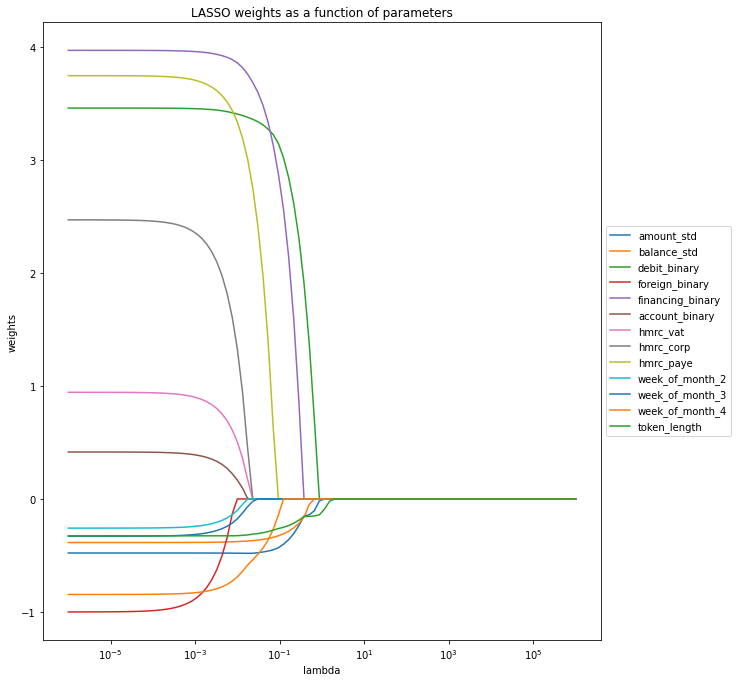

In [21]:
#plot the lasso graph to show importance virtually
X_colLabels=X_num_feat.columns
fig = plt.figure(figsize = (10,25))
ax = fig.add_subplot(212)
ax.plot(lambda_list, weights_lasso)
ax.set_xscale('log')
ax.legend(labels = X_colLabels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('lambda')
plt.ylabel('weights')
plt.title('LASSO weights as a function of parameters')
plt.savefig(r'lasso_trad.png',bbox_inches='tight')

## 3. Feature Selection

In [8]:
#Final model selected at model selection stage
mlp = MLPClassifier(activation= 'relu',alpha= 0.05,hidden_layer_sizes= (200,200),learning_rate= 'constant',solver= 'adam')
kfold = StratifiedKFold(n_splits=5,random_state=200,shuffle=True)

#selection is conducted by defining features to be dropped
def feat_selection(drop_fea_dict):
    feat_result = dict()
    for key, value in drop_fea_dict.items():
        X = drop_column(X_train,value)
        score = cross_val_score(mlp, X, y_train, cv=kfold, scoring='f1_macro', n_jobs=-1)
        feat_result[key] = score.mean()
        print('drop ({}) : {}'.format(key, score.mean()))

In [9]:
#defining features to be dropped
drop_feat = {
    'foreign_binary' : ['foreign_binary'],
    'account_binary' : ['account_binary'],
    'week_of_month_2':['week_of_month_2'],
    'week_of_month_2+week_of_month_3':['week_of_month_2','week_of_month_3'],
    'foreign_binary+account_binary': ['foreign_binary', 'account_binary'],
    'foreign_binary+account_binary+week_of_month_2' :['foreign_binary', 'account_binary','week_of_month_2'],
    'week_of_month_2+week_of_month_3+account_binary':['week_of_month_2','week_of_month_3','account_binary'],
    'foreign_binary+account_binary+week_of_month_2+hmrc_vat' :['foreign_binary', 'account_binary','week_of_month_2','hmrc_vat'],
    'week_of_month_2+week_of_month_3+account_binary+token_length':['week_of_month_2','week_of_month_3','account_binary','token_length'],
    'foreign_binary+account_binary+week_of_month_2+hmrc_vat+hmrc_corp' :['foreign_binary', 'account_binary','week_of_month_2','hmrc_vat','hmrc_corp'],
    'week_of_month_2+week_of_month_3+account_binary+token_length+balance_std':['week_of_month_2','week_of_month_3','account_binary','token_length','balance_std'],
    'foreign_binary+account_binary+week_of_month_2+hmrc_vat+hmrc_corp+week_of_month_3' :['foreign_binary', 'account_binary','week_of_month_2','hmrc_vat','hmrc_corp','week_of_month_3'],
    'week_of_month_2+week_of_month_3+account_binary+token_length+balance_std+amount_std':['week_of_month_2','week_of_month_3','account_binary','token_length','balance_std','amount_std'],
    'hmrc_corp+hmrc_vat+foreign_binary+week_of_month_2+week_of_month_3+hmrc_paye+account_binary+balance_std' :['hmrc_corp', 'hmrc_vat','foreign_binary','week_of_month_2','week_of_month_3','hmrc_paye','account_binary','balance_std'],
}

#create a benchmark model and its f1 score
bench = cross_val_score(mlp, X_train, y_train, cv=kfold, scoring='f1_macro', n_jobs=-1)
print('benchmark model : {}'.format(bench.mean()))

feat_selection(drop_feat)

benchmark model : 0.9434711443350847
drop (foreign_binary) : 0.9444163808885386
drop (account_binary) : 0.9424767136656994
drop (week_of_month_2) : 0.9419114901814909
drop (week_of_month_2+week_of_month_3) : 0.9354046630875675
drop (foreign_binary+account_binary) : 0.9448439904840503
drop (foreign_binary+account_binary+week_of_month_2) : 0.9397914330405162
drop (week_of_month_2+week_of_month_3+account_binary) : 0.9328572551071433
drop (foreign_binary+account_binary+week_of_month_2+hmrc_vat) : 0.9369230622491097
drop (week_of_month_2+week_of_month_3+account_binary+token_length) : 0.9325691267278582
drop (foreign_binary+account_binary+week_of_month_2+hmrc_vat+hmrc_corp) : 0.9360485577730551
drop (week_of_month_2+week_of_month_3+account_binary+token_length+balance_std) : 0.9347590025157659
drop (foreign_binary+account_binary+week_of_month_2+hmrc_vat+hmrc_corp+week_of_month_3) : 0.9408682963135554
drop (week_of_month_2+week_of_month_3+account_binary+token_length+balance_std+amount_std) : 0